<a href="https://colab.research.google.com/github/MinghanChu/BashonGithub/blob/master/Copy_of_Training_Deep_NN_on_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# Use a white background for matplotlib figures
matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16072846.05it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 490374.31it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3914745.62it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8024654.07it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Let's look at a couple of images from the dataset. The images are converted to PyTorch tensors with the shape `1x28x28` (the dimensions represent color channels, width and height). We can use `plt.imshow` to display the images. However, `plt.imshow` expects channels to be last dimension in an image tensor, so we use the `permute` method to reorder the dimensions of the image.

image.shape: torch.Size([1, 28, 28])
Label: 5


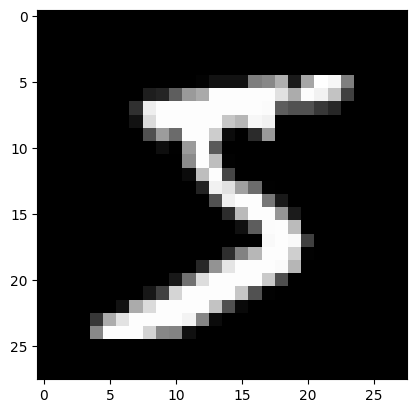

In [3]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

image.shape: torch.Size([1, 28, 28])
Label: 5


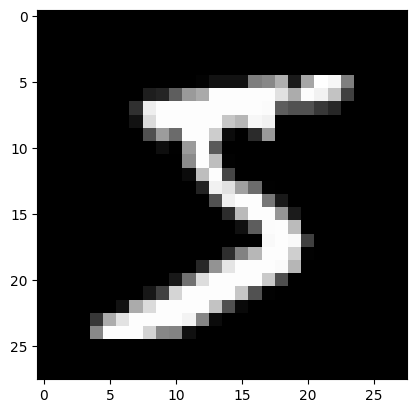

In [4]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image.permute(1, 2, 0), cmap='gray')
print('Label:', label)

Next, let's use the `random_split` helper function to set aside 10000 images for our validation set.

In [5]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

We can now create PyTorch data loaders for training and validation.

In [6]:
batch_size=128

In [7]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


+ `num_workers=4`: Setting the argument num_workers as a positive integer will turn on multi-process data loading with the specified number of loader worker processes

+ setting `pin_memory=True`, which enables **fast data transfer to CUDA-enabled GPUs**

+ setting `shuffle=True` for the training data loader to ensure that the batches generated in each epoch are different.

+ note no need to set `shuffle=True` for the validation data loader because the validation data loader is used only for evaluating the model, there is no need to shuffle the images.

Let's visualize a batch of data in a grid using the `make_grid` function from `torchvision`. We'll also use the `.permute` method on the tensor to move the channels to the last dimension, as expected by `matplotlib`.

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


images.shape: torch.Size([128, 1, 28, 28])


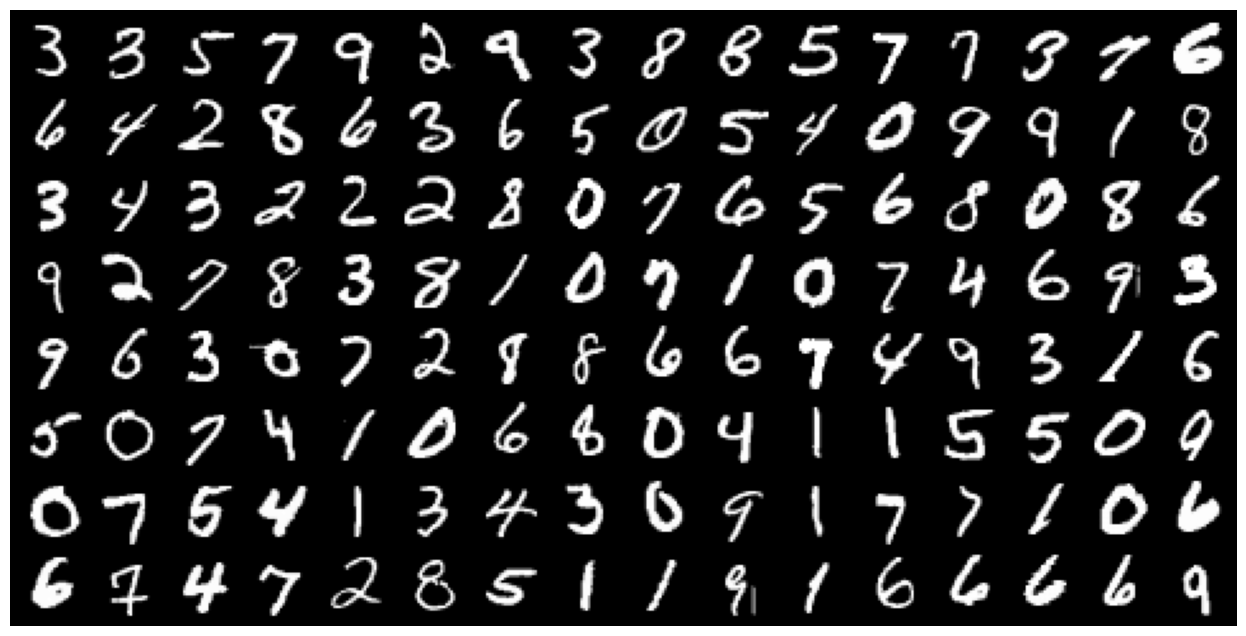

In [8]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## Hidden Layers, Activation Functions and Non-Linearity

We'll create a neural network with two layers: a *hidden layer* and an *output layer*. Additionally, we'll use an activation function between the two layers. Let's look at a step-by-step example to learn how hidden layers and activation functions can help capture **non-linear relationships** between inputs and outputs.

First, let's create a batch of inputs tensors. We'll flatten the `1x28x28` images into vectors of size `784`, so they can be passed into an `nn.Linear` object.

In [9]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


Next, let's create a `nn.Linear` object, which will serve as our `hidden` layer. (Note the hidden layer is a linear model.) We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the *learning capacity* of the model.

In [10]:
input_size = inputs.shape[-1]
print(input_size)
hidden_size = 32

784


In [11]:
layer1 = nn.Linear(input_size, hidden_size)

We can now compute intermediate outputs for the batch of images by passing `inputs` through `layer1`.

In [12]:
inputs.shape

torch.Size([128, 784])

In [13]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


The image vectors of size `784` are transformed into intermediate output vectors of length `32` by performing a matrix multiplication of `inputs` matrix with transposed weights matrix of `layer1` and adding the bias. We can verify this using `torch.allclose`.

In [14]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [15]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

True

Thus, `layer1_outputs` and `inputs` have a linear relationship, i.e., each element of `layer_outputs` is a weighted sum of elements from `inputs`. Thus, even as we train the model and modify the weights, `layer1` can only capture line relationships between `inputs` and `outputs`.

<img src="https://i.imgur.com/inXsLuq.png" width="360">

Next, we'll use the Rectified Linear Unit (ReLU) function as the activation function for the outputs. It has the formula `relu(x) = max(0,x)` i.e. it simply replaces negative values in a given tensor with the value 0. ReLU is a non-linear function, as seen here visually:

<img src="https://i.imgur.com/yijV4xF.png" width="420">

We can use the `F.relu` method to apply ReLU to the elements of a tensor.

In [16]:
F.relu(torch.tensor([[1, -1, 0],
                     [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

Let's apply the activation function to `layer1_outputs` and verify that negative values **were replaced with 0**.

In [17]:
relu_outputs = F.relu(layer1_outputs)
print(relu_outputs.shape)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

torch.Size([128, 32])
min(layer1_outputs): -0.673129677772522
min(relu_outputs): 0.0


Applying nonlinear activation function, `relu_outputs` and `inputs` do not have a linear relationship, e.g., `nn.Linear`. For each input certain outputs are activated (those with nonzero values) while others turned off (those with zero values).

Next, convert vectors of length `hidden_size` (originally not 10, in this particular example it is 32) in `relu_outputs` into vectors of length 10, which is the desired output of our model (since there are 10 target labels).

Let's create an output layer to convert vectors of length `hidden_size` in `relu_outputs` into vectors of length 10, which is the desired output of our model.

+ Mathematically: `output = input * weight^T + bias`

In [18]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size) # layer 2 is also based on a linear model
print(hidden_size)
print(output_size)

32
10


The nn.Linear layer in PyTorch (and similarly in many other deep learning frameworks) is designed to work with the feature dimension, which is always the second dimension of the input tensor when the input is a 2D tensor (i.e., batches of samples).

The call `layer2_outputs = layer2(relu_outputs)` will only work correctly if the size of `relu_outputs` is compatible with the expected input size of `layer2`

`layer2 = nn.Linear(hidden_size, output_size)` initializes a linear layer expecting input with `hidden_size` features.

`layer2(relu_outputs)` will work if `relu_outputs` has a shape `[batch_size, hidden_size]`

Ensure `hidden_size`in `nn.Linear(hidden_size, output_size)` matches the second dimension of `relu_outputs`

In [19]:
layer2_outputs = layer2(relu_outputs)
print(relu_outputs.shape)
print(layer2_outputs.shape)


torch.Size([128, 32])
torch.Size([128, 10])


As expected, `layer2_outputs` contains a batch of vectors of size 10. We can  now use this output to compute the loss using `F.cross_entropy`

In [20]:
inputs.shape

torch.Size([128, 784])

As expected, `layer2_outputs` contains a batch of vectors of size 10. We can now use this output to compute the loss using `F.cross_entropy` and adjust the weights of `layer1` and `layer2` using gradient descent.

In [21]:
print(layer2_outputs.shape)
layer2_outputs

torch.Size([128, 10])


tensor([[-0.0579,  0.1388, -0.0137,  ...,  0.0575,  0.0835, -0.1066],
        [-0.0161,  0.1113, -0.0160,  ...,  0.0562,  0.0410, -0.0733],
        [-0.0796,  0.0966,  0.0189,  ..., -0.0662,  0.1025, -0.0632],
        ...,
        [-0.0752,  0.1963, -0.0622,  ...,  0.0613,  0.0461, -0.1876],
        [-0.0407,  0.1420, -0.0639,  ..., -0.0199,  0.1806, -0.0486],
        [ 0.0125,  0.1491, -0.0655,  ...,  0.0640, -0.0349, -0.1316]],
       grad_fn=<AddmmBackward0>)

In [22]:
labels.shape

torch.Size([128])

Thus, our model transforms

Cross-entropy is a widely used loss function in machine learning and statistics, particularly in the context of classification problems. It measures the **difference between two probability distributions**, often the **predicted probability distribution and the true probability distribution (or labels)**.

In [23]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.2994, grad_fn=<NllLossBackward0>)

Thus, our model transforms `inputs` into `layer2_outputs` by applying a linear transformation (using `layer1`),

1.  `layer1_outputs = inputs @ layer1.weight.t() + layer1.bias`

followed by a non-linear activation (using `F.relu`),

2. `relu_outputs = F.relu(step1)`

followed by another linear transformation (using `layer2`).

3. `layer2_outputs = layer2(relu_outputs)`

Let's verify this by re-computing the output using basic matrix operations.

In [24]:
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias

In [25]:
torch.allclose (outputs, layer2_outputs, 1e-3)

True

Note that `outputs` and `inputs` do not have a linear relationship due to the **non-linear activation function** `F.relu`. As we train the model and adjust the weights of `layer1` and `layer2`, we can now capture non-linear relationships between the images and their labels. In other words, **introducing non-linearity** makes the model more powerful and versatile. Also, since `hidden_size` does not depend on the dimensions of the inputs or outputs, we vary it to increase the number of parameters within the model. We can **also introduce new hidden layers and apply the same non-linear activation after each hidden layer**.

**The model we just created is called a neural network**. **A _deep neural network_ is simply a neural network with one or more hidden layers.** In fact, the [Universal Approximation Theorem](http://neuralnetworksanddeeplearning.com/chap4.html) states that a sufficiently large & deep neural network can compute any arbitrary function i.e. it **can _learn_ rich and complex non-linear relationships between inputs and targets**. Here are some examples:

* Identifying if an image contains a cat or a dog (or [something else](https://machinelearningmastery.com/introduction-to-the-imagenet-large-scale-visual-recognition-challenge-ilsvrc/))
* Identifying the genre of a song using a 10-second sample
* Classifying movie reviews as positive or negative based on their content
* Navigating self-driving cars using a video feed of the road
* Translating sentences from English to French (and hundreds of other languages)
* Converting a speech recording to text and vice versa
* And many more...

It's hard to imagine how the simple process of multiplying inputs with randomly initialized matrices, **applying non-linear activations, and adjusting weights repeatedly using gradient descent can yield such astounding results**. Deep learning models often contain **millions of parameters, which can together capture far more complex relationships** than the human brain can comprehend.

If we hadn't included a non-linear activation between the two linear layers, the final relationship between inputs and outputs would still be linear. A simple refactoring of the computations illustrates this.

Key Goal: we need to understand what it really means regarding nonlinearity being introduced in the deep learning model.

Nonlinearity captures the behavior more close to the reality.

In [26]:
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

`layer2.weight @ layer1.weight`

This operation effectively combines the linear transformations of two layers into one. The resultant matrix can be seen as a **single layer's weight matrix** that directly maps the input of layer1 to the output of layer2.

The expression `layer1.bias @ layer2.weight.t() + layer2.bias` effectively transforms the bias of the first layer through the transposed weight matrix of the second layer and then shifts it by the bias of the second layer. This operation can be useful for combining and analyzing the effects of biases across multiple layers in a neural network.

In [27]:
combined_layer = nn.Linear(input_size, output_size)
combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In the provided code snippet, you are creating a new linear layer (combined_layer) and manually setting its weights and biases based on the operations involving the weights and biases of two existing layers (layer1 and layer2).

`combined_layer = nn.Linear(input_size, output_size)
`
This initializes a new linear layer with the specified input and output sizes. This layer will have its own randomly initialized weights and biases.

`combined_layer.weight.data = layer2.weight @ layer1.weight
`

This line replaces the randomly initialized weights of combined_layer with the result of the matrix multiplication of `layer2.weight` and `layer1.weight`. The result of `layer2.weight @ layer1.weight` forms the new weight matrix for `combined_layer`.

`combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias`

This line replaces the **randomly initialized biases of `combined_layer`** with the result of a combination of `layer1.bias and layer2.bias`. Specifically, it computes the product of `layer1.bias` and the transpose of `layer2.weight`, then adds `layer2.bias` to it.


In [28]:
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

In [29]:
torch.allclose(outputs2, outputs3, 1e-3)

True

## Model

We are now ready to define our model. As discussed above, we'll create a neural network with **one hidden layer**. Here's what that means:

* Instead of using a single `nn.Linear` object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two `nn.Linear` objects. Each of these is called a _layer_ in the network.

* The first layer (also known as the hidden layer) will transform the input matrix of shape `batch_size x 784` into an intermediate output matrix of shape `batch_size x hidden_size`. The parameter `hidden_size` can be configured manually (e.g., 32 or 64).

* We'll then apply a non-linear *activation function* to the intermediate outputs. The activation function transforms individual elements of the matrix.

* The result of the activation function, which is also of size `batch_size x hidden_size`, is passed into the second layer (also known as the output layer).  The second layer transforms it into a matrix of size `batch_size x 10`. We can use this output to compute the loss and adjust weights using gradient descent.


As discussed above, our model will contain one hidden layer. Here's what it looks like visually:

<img src="https://i.imgur.com/eN7FrpF.png" width="480">


Let's define the model by extending the `nn.Module` class from PyTorch.

The nn.Module class in PyTorch is a base class for all neural network modules.

Let's define the new model by extending the `nn.Module` class from PyTorch.

`super().__init__()` calls the constructor of the parent class nn.Module. This is necessary to properly initialize the base class, enabling the MnistModel to inherit all the functionalities of nn.Module

In [30]:
class MnistModel(nn.Module):
    "Feedfoward neural network with 1 hidden layer"
    def __init__(self, in_size, hidden_size, out_size): # constructor method
        super().__init__() #instantiate the constructor in the parent class
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss:{:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

We also need to define an `accuracy` function which calculates the accuracy of the model's prediction on an batch of inputs. It's used in `validation_step` above.

In [31]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))

we'll create a model that contains a hidden layer with 32 activations.

In [32]:
input_size = 784
hidden_size = 32
num_classes = 10

In [33]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

Let's take a look at the model's parameters. We expect to see one weight and bias matrix for each of the layers.

In [34]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


Let's try and generate some outputs using our model. We'll take the first batch of 128 images from our dataset and pass them into our model.

In [35]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2941665649414062
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.2532,  0.1108, -0.0245, -0.1299,  0.1371,  0.1035, -0.0530,  0.0132,
         -0.0435, -0.0833],
        [ 0.3052, -0.0290,  0.0098, -0.0058,  0.2116,  0.0768, -0.2242,  0.1404,
          0.0818, -0.1021]])


## Using a GPU

As the sizes of our models and datasets increase, we need to use GPUs to train our models within a reasonable amount of time. GPUs contain **hundreds of cores** optimized for performing expensive matrix operations on floating-point numbers quickly, making them ideal for training deep neural networks. You can use GPUs for free on [Google Colab](https://colab.research.google.com/) and [Kaggle](https://www.kaggle.com/kernels) or rent GPU-powered machines on services like [Google Cloud Platform](https://cloud.google.com/gpu/), [Amazon Web Services](https://docs.aws.amazon.com/dlami/latest/devguide/gpu.html), and [Paperspace](https://www.paperspace.com/).

We can check if a GPU is available and the required NVIDIA CUDA drivers are installed using `torch.cuda.is_available`.

In [36]:
torch.cuda.is_available()

False

check which is avaiable to use: 'cpu' vs 'gpu'


In [37]:
def get_default_device():
    """Pick GPU if available, else CPU """
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [38]:
device = get_default_device()
device

device(type='cpu')

+ `if isinstance(data, (list, tuple)):` This line checks if data is either a `list` or a `tuple`. The `isinstance` function is used for this purpose, and it checks if data is an instance of either `list` or `tuple`.

+ Note both `list` and `tuple` are classes in Python. They are part of the built-in data types provided by the Python standard library.

+ `if isinstance(data, (list, tuple)):` outputs true or false

+ `return [to_device(x, device) for x in data]` If data is a list or tuple, this line uses a list comprehension to iterate over each element `x` in data and applies the `to_device` function to each element. The result is a new list (or tuple) where each element has been moved to the specified device. The list comprehension effectively creates a new list by applying the `to_device` function **recursively to each element in the original list or tuple**.

+ `return data.to(device, non_blocking=True)` if the data is neither a list nor a tuple, then it is a vector. An instance of a PyTorch tensor includes the mehod called `.to(device)`. This method is used to move the tensor to a specified device (CPU, GPU, etc.).


In [39]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
      return [to_device(x, device) for x in data] # applies to_device function recursively to each element in the original list or tuple (data)
    return data.to(device, non_blocking=True)

In [40]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cpu


Defining a `DeviceDataLoader` class to **wrap** our existing data loader (an object) and move batches of data to the selected device. No need to extend an existing class to create a PyTorch dataloader. All we need is an `__iter__` method to retrieve batches of data and an `__len__` method to get the number of batches.

+ `__init__(self, dl, device):` Method: This is the constructor method for the class.

  `dl`: This parameter represents the original data loader that you want to wrap. It is expected to be an iterable that yields batches of data.

  `device`: This parameter represents the device to which the data should be moved (e.g., `torch.device('cuda')` for GPU or `torch.device('cpu')` for CPU)

  The constructor stores these parameters in instance variables `self.dl` and `self.device`.

  Note when wrapping the original data loader (`dl`), we mean that you are creating a new object (an instance of `DeviceDataLoader`) that takes the original data loader as input and provides additional functionality or behavior. In this case, the additional behavior is moving the data to a specified device (like a GPU or CPU) before yielding each batch. Here the **original data loader** refers to the `dl` object (instance from vector/list/tuple class defined in standard python library).

  Wrapping is a common programming pattern where you create a new **interface** to an existing object. The new interface typically adds, modifies, or extends the functionality of the original object without changing its core behavior.

+ `__iter__(self)` Method: This method makes the `DeviceDataLoader` class **iterable**, allowing it to be used in **a for loop** or any other context where iteration is required.

  The method iterates over the batches of data produced by `self.dl`
  
  For each batch `b`, it calls `to_device(b, self.device)`, which is assumed to be a function that moves the batch to the specified device.

  The `yield` statement returns each batch after moving it to the device, one at a time, making the `DeviceDataLoader` an iterator.

  Note **an iterable** is any Python object that can be used in a loop (e.g., `for` loop). This means the object must implement the `__iter__` method, which returns an iterator. An **iterator is an object** that has a `__next__` method, which returns the next item in the sequence and raises a `StopIteration` exception when there are no more items.

  Examples of iterables

  + List: `[1, 2, 3]`
  + Tuples: `(1, 2, 3)`
  + Dictionaries: `{1: 'a', 2: 'b', 3: 'c'}`
  + Strings: `"hello"`

+ `__len__(self)` Method: This method allows the `DeviceDataLoader` to respond to the `len()` function, returning the number of batches in the data loader.

  It simply returns the length of the original data loader `self.dl`

In [41]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

When using a **normal function** in a `for` loop, the function needs to return an iterable object. This iterable object can be a `list`, `tuple`, `dictionary`, or any other object that implements the `__iter__` method.

For example, if you have a function that returns a list of numbers, you can iterate over the `list` using a `for` loop:

In [42]:
def get_numbers():
    return [1, 2, 3, 4, 5]

for num in get_numbers():
    print(num)


1
2
3
4
5


`yield` to produce a generator function that is used in a `for` loop.

A **generator function** is a special type of function that uses the `yield` keyword to produce a series of values **lazily**, **one at a time**`. Each time `yield` is called, the function temporarily suspends its execution, yielding control back to the caller, but it remembers its state so that it can resume where it left off the next time it's called.

**Normal function vs generator function**

1. Normal Function: Returns a complete list of numbers when called.
2. Generator Function: Produces numbers lazily, one at a time, each time it's called.

**Advantages of Generator functions**
1. Efficiency: Generator functions are memory-efficient because they produce values on-the-fly without storing them all in memory at once.

2. Lazy Evaluation: Values are generated only when needed, allowing for efficient processing of large datasets or infinite sequences.

Both **normal function** and **generator function** can be used in a `for` loop, while generator functions created using `yield` provide a convenient way to produce a **sequence of values lazily**, making them well-suited for iteration in a for loop.

We can now wrap our data loaders using `DeviceDataLoader`.

In [43]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

PyTorch tensors have a `.device` attribute, which indicates the device (e.g., CPU or GPU) where the tensor is located.

+ `xb`: This is a batch of input data tensors.
+ `yb`: This is likely a batch of target (label) tensors.
+ `xb.device`: This retrieves the device on which the input data tensors are located.

In [44]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cpu
yb: tensor([1, 5, 5, 5, 2, 8, 3, 3, 6, 5, 2, 4, 2, 8, 9, 1, 7, 4, 2, 4, 2, 7, 6, 1,
        2, 0, 5, 6, 6, 6, 9, 2, 1, 5, 0, 2, 7, 7, 3, 4, 2, 7, 7, 3, 0, 4, 6, 1,
        6, 7, 7, 7, 9, 8, 5, 8, 0, 3, 6, 8, 1, 2, 9, 6, 7, 6, 9, 0, 3, 0, 7, 9,
        0, 8, 9, 2, 5, 7, 3, 2, 8, 9, 7, 9, 3, 6, 8, 9, 3, 9, 1, 3, 0, 0, 4, 1,
        1, 0, 2, 1, 0, 9, 8, 9, 3, 7, 7, 8, 3, 1, 6, 6, 4, 0, 1, 7, 4, 6, 7, 9,
        2, 9, 1, 5, 6, 7, 1, 1, 9, 1, 7, 7, 3, 1, 1, 8, 0, 9, 0, 8, 0, 0, 0, 2,
        9, 4, 0, 2, 9, 3, 5, 3, 7, 0, 9, 8, 0, 5, 9, 6, 4, 0, 8, 2, 1, 7, 1, 4,
        8, 9, 0, 8, 7, 2, 9, 5, 0, 8, 4, 5, 0, 7, 1, 9, 1, 4, 7, 2, 1, 3, 3, 8,
        0, 4, 3, 0, 6, 2, 3, 8, 0, 9, 1, 3, 0, 4, 1, 7, 7, 7, 3, 9, 7, 4, 8, 9,
        5, 4, 0, 6, 3, 1, 1, 3, 9, 0, 3, 6, 6, 8, 0, 3, 7, 1, 9, 0, 4, 0, 1, 8,
        8, 5, 4, 8, 3, 9, 3, 9, 2, 3, 0, 1, 6, 0, 9, 7])


## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set.

+ Initialization: It initializes an empty `list history` to store the performance metrics of the model during training.

+ It iterates over the **specified number of epochs**.

+ Within each epoch, it iterates over the batches in the `train_loader`. `fit` is responsible for training the model using gradient descent, including both the **training and validation phases** for each epoch.

+ `optimizer` object is responsible for updating the parameters of the model during training

  + there are common optimization algorithms: `Stochastic Gradient Descent (torch.optim.SGD)`, `Adam (torch.optim.RMSprop)`, `Adagrad(torch.optim.Adagrad)`

+ For each batch, it performs a forward pass through the model (`training_step`), computes the loss, performs backpropagation, and **updates the model parameters using the optimizer**

+ After each epoch, it evaluates the model's performance on the **validation set** by calling the `evaluate` function.

In [45]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr) # opt_func is a placeholder, and in this example opt_func = torch.optim.SGD
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch) # calculates the loss between the model's predictions and the true labels. This loss value is often represented as a PyTorch tensor
            loss.backward()  # computes the gradients of the loss wrt all the tensors that were involved in the computation of the loss
            optimizer.step() # after the gradients have been computed, this step updates the parameters of the model using the gradients computed during the backward pass
            optimizer.zero_grad() # after updating the model parameters, it is important to zero out the gradients of all parameters before the next iteration.
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

+ `for batch in train_loader:` This loop iterates over batches of data from the training dataset. Each batch typically contains input data and corresponding target labels

+ This `loss` (`loss = model.training_step(batch)`) value is often represented as a PyTorch tensor. Here `loss` is an instance of of a PyTorch tensor, which includes the `backward()` method. It performs backpropagation.

+ `optimizer.zero_grad()` resets all gradients to zero so that they can be recalculated for the next batch.

+ `optimizer = opt_func(model.parameters(), lr)`, `opt_func` is a variable representing a function that instantiates an optimizer object. The name `opt_func` is just a placeholder; it can be replaced with any valid variable name.

Before we train the model, we need to ensure that the data and the model's parameters (weights and biases) are on the same device (CPU or GPU). We can reuse the `to_device` function to move the model's parameters to the right device.

In [46]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

Let's see how the model performs on the validation set with the initial set of weights and biases.

+ The result of `evaluate(model, val_loader)` is placed inside a list

+ history is initialized as a list containing a **single element**, which is the result of the evaluate function.

+ After each epoch, the model is evaluated on the validation set, and the result is appended to the history list.

In [47]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 2.31705641746521, 'val_acc': 0.05322265625}]

The initial accuracy is around 10%, as one might expect from a randomly initialized model (since it has a 1 in 10 chance of getting a label right by guessing randomly).

Let's train the model for five epochs and look at the results. We can use a relatively high learning rate of 0.5.

+ The += operator in Python is used to perform in-place addition
+ The += operator in the context of `lists` performs concatenation, meaning it appends the elements of the right-hand side list to the left-hand side list. This is a common operation when managing sequences of data in Python
+ `history` is a `list`

In [48]:
history += fit(5, 0.5, model, train_loader, val_loader)

Epoch [0], val_loss:0.2758, val_acc: 0.9193
Epoch [1], val_loss:0.1770, val_acc: 0.9451
Epoch [2], val_loss:0.1506, val_acc: 0.9567
Epoch [3], val_loss:0.1464, val_acc: 0.9540
Epoch [4], val_loss:0.1549, val_acc: 0.9513


96% is pretty good! Let's train the model for five more epochs at a lower learning rate of 0.1 to improve the accuracy further.

In [49]:
history += fit(5, 0.1, model, train_loader, val_loader)

Epoch [0], val_loss:0.1177, val_acc: 0.9648
Epoch [1], val_loss:0.1157, val_acc: 0.9667
Epoch [2], val_loss:0.1159, val_acc: 0.9654
Epoch [3], val_loss:0.1139, val_acc: 0.9664
Epoch [4], val_loss:0.1153, val_acc: 0.9666


We can now plot the losses & accuracies to study how the model improves over time.

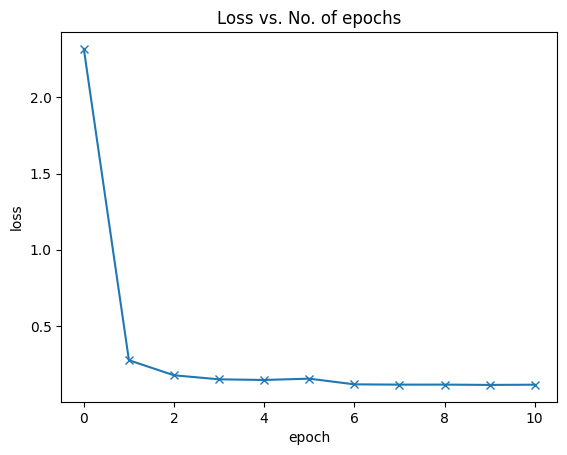

In [50]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

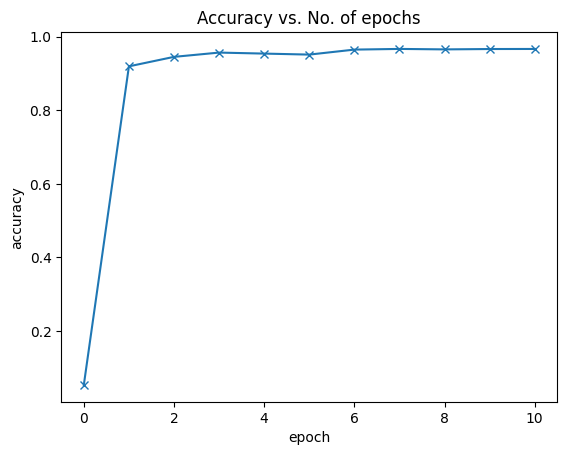

In [51]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

The current model outperforms the **logistic regression model** (which could only achieve around 86% accuracy) by a considerable margin! It quickly reaches an accuracy of 97% but **doesn't improve much beyond this**. To improve accuracy further, we need to make the model **more powerful** by **increasing the hidden layer's size** or **adding more hidden layers** with activations.